# EDA, ETL CREACION DE DF FINAL Y MODELO DE BLOQUES VACIOS

In [2]:
#importación de bibliotecas a utilizar

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import plotly.express as px
%matplotlib inline



# Exploramos la base de datos

### Assays

In [2]:
assays = pd.read_csv("assays.csv", sep=",")
assays.head()

,BHID,FROM,TO,AU,AG,CU,LENGTH
0,101,0.000000,120.318986,-,-,-,120.318986
1,101,120.318986,121.776873,2.2834,49.61135459,0.75531497,1.457887
2,101,121.776873,124.276873,4.03565,108.8772502,0.06997427,2.500000
3,101,124.276873,126.776873,4.05984,92.62225802,0.04769875,2.500000
4,101,126.776873,129.276873,1.36533,51.69051878,0.11736973,2.500000


In [3]:
assays.describe().T

,count,mean,std,min,25%,50%,75%,max
BHID,7058.0,173.975914,43.397723,101.000000,139.000000,171.000000,206.000000,269.000000
FROM,7058.0,264.053418,91.484615,0.000000,203.798933,266.329355,335.315512,444.249650
TO,7058.0,271.757581,83.707399,36.914310,209.187837,270.926780,338.940865,445.681684
LENGTH,7058.0,7.704164,37.655371,0.017708,2.500000,2.500000,2.500000,442.680286


In [4]:
assays.info()
assays.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7058 entries, 0 to 7057
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BHID    7058 non-null   int64  
 1   FROM    7058 non-null   float64
 2   TO      7058 non-null   float64
 3   AU      7058 non-null   object 
 4   AG      7058 non-null   object 
 5   CU      7058 non-null   object 
 6   LENGTH  7058 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 386.1+ KB


BHID      0
FROM      0
TO        0
AU        0
AG        0
CU        0
LENGTH    0
dtype: int64

In [5]:
# Reemplazar guiones por NaN
assays.replace('-', np.nan, inplace=True)

# Convertir columnas de leyes a float
for col in ["AU", "AG", "CU"]:
    assays[col] = assays[col].astype(float)


In [6]:
assays.isna().sum()


BHID      0
FROM      0
TO        0
AU        1
AG        1
CU        1
LENGTH    0
dtype: int64

In [7]:
assays[assays.isna().any(axis=1)]


,BHID,FROM,TO,AU,AG,CU,LENGTH
0,101,0.0,120.318986,NaN,NaN,NaN,120.318986


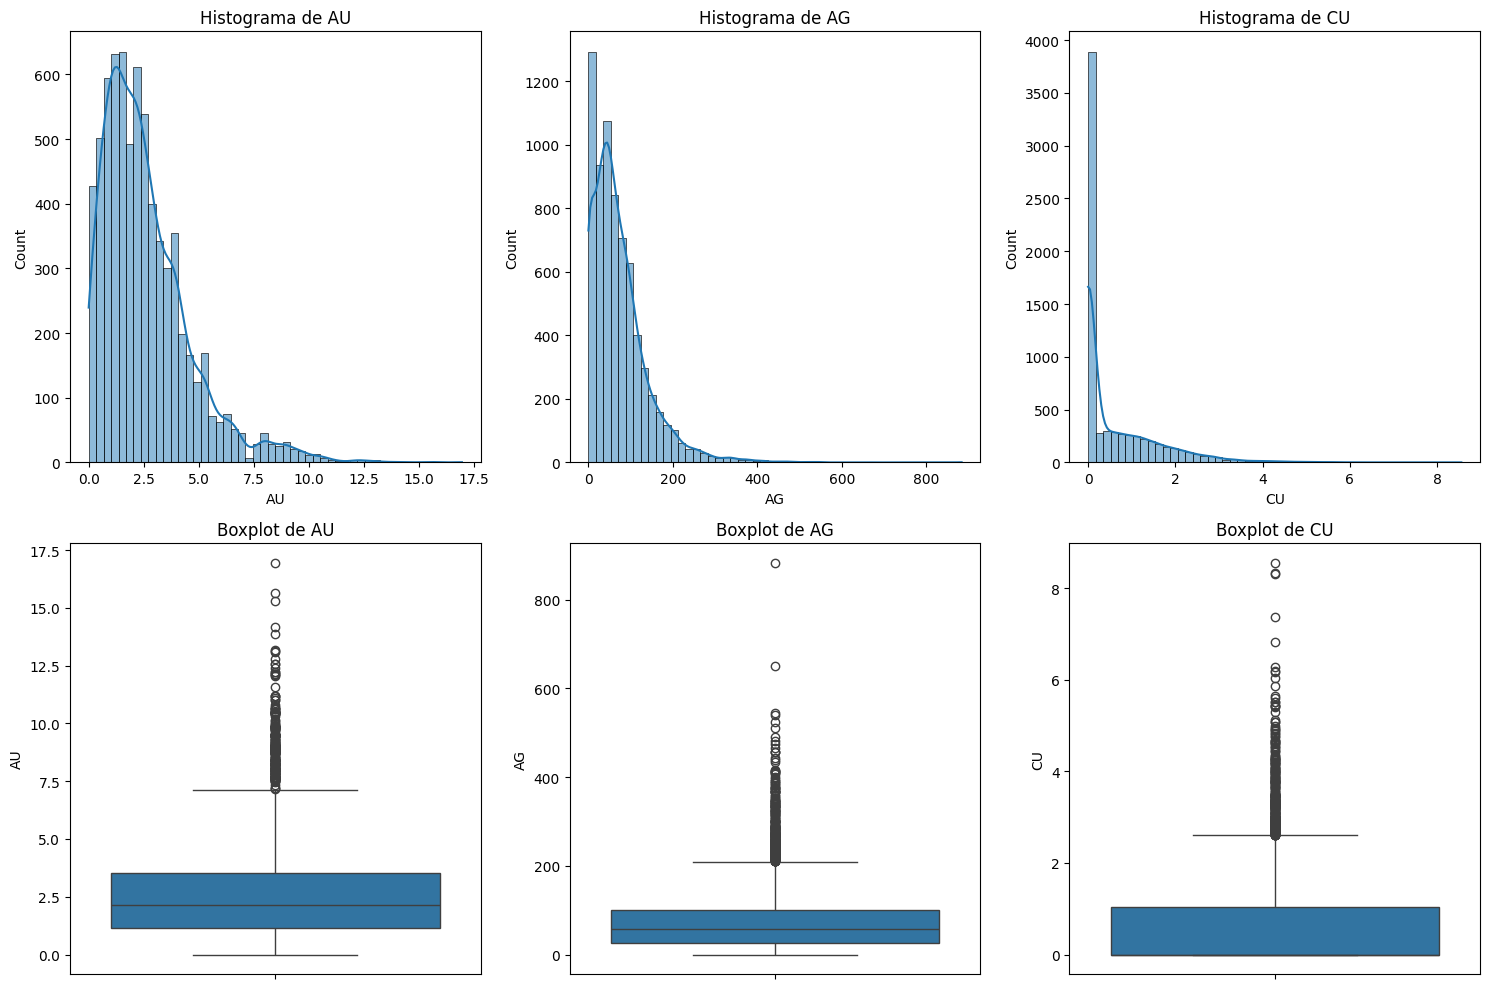

In [8]:
import seaborn as sns

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, col in enumerate(["AU", "AG", "CU"]):
    sns.histplot(assays[col], bins=50, ax=axs[0, i], kde=True)
    axs[0, i].set_title(f"Histograma de {col}")

    sns.boxplot(y=assays[col], ax=axs[1, i])
    axs[1, i].set_title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()


los circulos representan los utliers si usamos la formula [Q1−1.5×IQR, Q3+1.5×IQR]


In [9]:
# Función para detectar outliers en cada columna
def detect_outliers(df, column):
    # Calcular Q1 (25 percentil) y Q3 (75 percentil)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    # Calcular el Rango Intercuartílico (IQR)
    IQR = Q3 - Q1
    # Definir los límites inferior y superior para detectar outliers (normalmente se usa 1.5)
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    # Detectar los outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Verificar la cantidad de outliers en cada columna (AU, AG, CU)
for col in ['AU', 'AG', 'CU']:
    outliers = detect_outliers(assays, col)
    print(f'Cantidad de outliers en {col}: {len(outliers)}')


Cantidad de outliers en AU: 26
Cantidad de outliers en AG: 74
Cantidad de outliers en CU: 59


acotamos maximos y minimos para esos outliers

In [10]:
for col in ["AU", "AG", "CU"]:
    q1 = assays[col].quantile(0.25)
    q3 = assays[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 3 * iqr
    upper = q3 + 3 * iqr
    assays[col] = assays[col].clip(lower, upper)    


In [11]:
assays["LENGTH_CALC"] = assays["TO"] - assays["FROM"]
assays["DIFF"] = np.abs(assays["LENGTH_CALC"] - assays["LENGTH"])

errores = assays[assays["DIFF"] > 0.01]  # tolerancia
print(f"{len(errores)} filas tienen errores en LENGTH.")


0 filas tienen errores en LENGTH.


In [12]:
negativos = assays[(assays["AU"] < 0) | (assays["AG"] < 0) | (assays["CU"] < 0)]
print(f"Filas con valores negativos: {len(negativos)}")

Filas con valores negativos: 0


In [13]:
# Ver duplicados exactos
duplicados = assays[assays.duplicated()]
print(f"Duplicados exactos: {len(duplicados)}")

# Ver duplicados por BHID + FROM + TO
duplicados_intervalo = assays[assays.duplicated(subset=["BHID", "FROM", "TO"])]
print(f"Duplicados por intervalo BHID+FROM+TO: {len(duplicados_intervalo)}")


Duplicados exactos: 0
Duplicados por intervalo BHID+FROM+TO: 0


### Collars

In [14]:
collars = pd.read_csv("collars.csv", sep=",")
collars.head()

,BHID,XCOLLAR,YCOLLAR,ZCOLLAR,DEPTH
0,101,1692.572266,537.331543,651.617371,197.862503
1,102,1738.934937,512.425842,648.128906,204.960571
2,103,1782.243286,487.253540,644.601990,212.488449
3,104,1824.748169,462.429993,651.518005,199.140854
4,105,1868.535400,443.595459,657.793640,185.006653


In [15]:
collars.describe().T

,count,mean,std,min,25%,50%,75%,max
BHID,158.0,183.582278,48.398849,101.000000,143.250000,182.500000,224.750000,269.000000
XCOLLAR,158.0,2042.765869,181.482035,1692.572266,1908.635865,2043.374878,2168.847412,2466.167236
YCOLLAR,158.0,780.304299,211.171842,334.410431,615.768173,788.104126,948.882889,1189.137573
ZCOLLAR,158.0,578.571344,35.827776,527.909485,546.319611,575.295868,602.463409,678.532227
DEPTH,158.0,344.151816,71.670352,144.891708,296.884811,350.841461,408.720085,445.681671


In [16]:
collars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BHID     158 non-null    int64  
 1   XCOLLAR  158 non-null    float64
 2   YCOLLAR  158 non-null    float64
 3   ZCOLLAR  158 non-null    float64
 4   DEPTH    158 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 6.3 KB


In [17]:
collars.isna().sum()


BHID       0
XCOLLAR    0
YCOLLAR    0
ZCOLLAR    0
DEPTH      0
dtype: int64

In [18]:
bhid_assays = set(assays['BHID'].unique())
bhid_collars = set(collars['BHID'].unique())
faltantes = bhid_assays - bhid_collars
print(f"BHID que están en assays pero no en collars: {len(faltantes)}")


BHID que están en assays pero no en collars: 0


In [19]:
max_to = assays.groupby('BHID')['TO'].max().reset_index()
merged = pd.merge(max_to, collars[['BHID', 'DEPTH']], on='BHID', how='left')
inconsistentes = merged[merged['TO'] > merged['DEPTH']]
print(f"Sondajes donde TO supera la profundidad del collar: {len(inconsistentes)}")


Sondajes donde TO supera la profundidad del collar: 70


In [20]:
print(merged[merged['TO'] > merged['DEPTH']].head(10))


    BHID          TO       DEPTH
3    104  199.140860  199.140854
6    107  202.807419  202.807419
9    110  236.114458  236.114456
11   112  253.394333  253.394333
14   115  226.852194  226.852188
15   116  234.581182  234.581177
16   117  210.969804  210.969803
20   122  283.064733  283.064728
22   124  249.911197  249.911194
24   126  263.661199  263.661194


la diferencia es minima, es cuestion de redondeo

In [21]:
tolerancia = 0.1
discrepancias = merged[merged['TO'] - merged['DEPTH'] > tolerancia]
print(f"Casos reales donde TO supera DEPTH por más de {tolerancia}: {len(discrepancias)}")


Casos reales donde TO supera DEPTH por más de 0.1: 0


In [22]:
duplicados = collars.duplicated(subset='BHID', keep=False)
print(f"Sondajes duplicados en collars: {duplicados.sum()}")

Sondajes duplicados en collars: 0


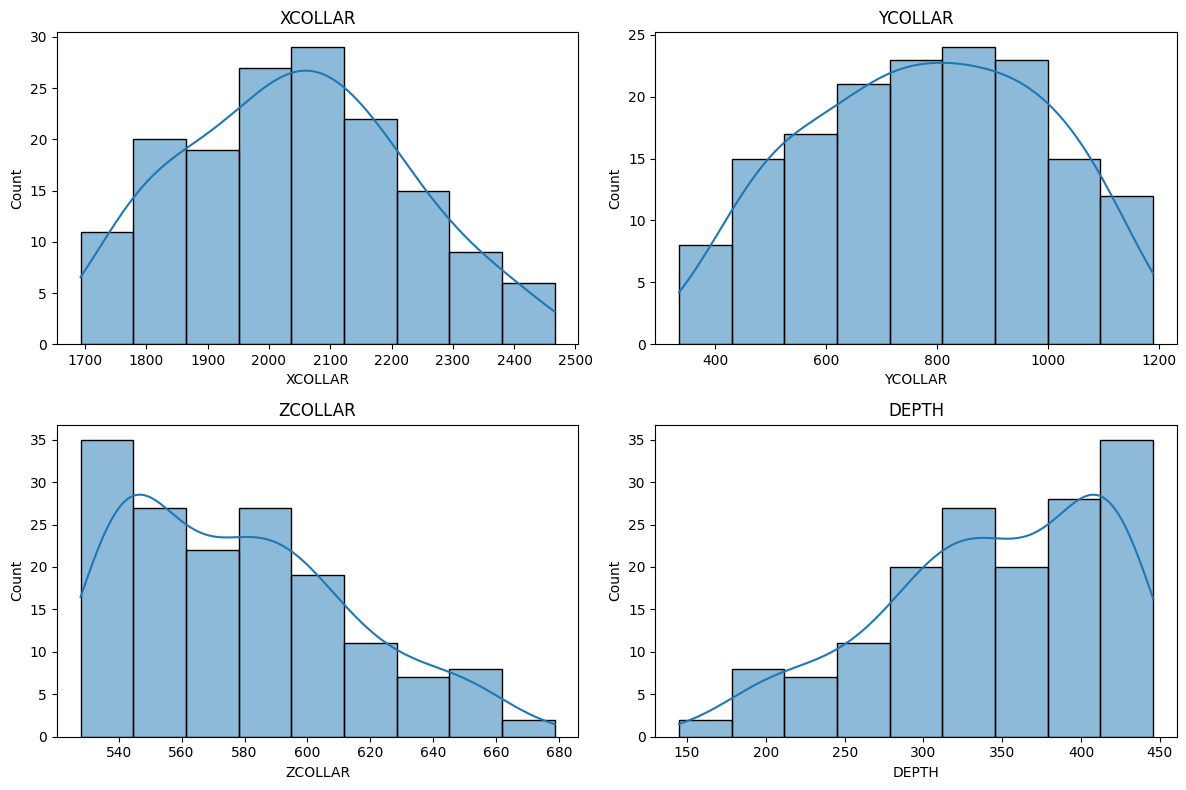

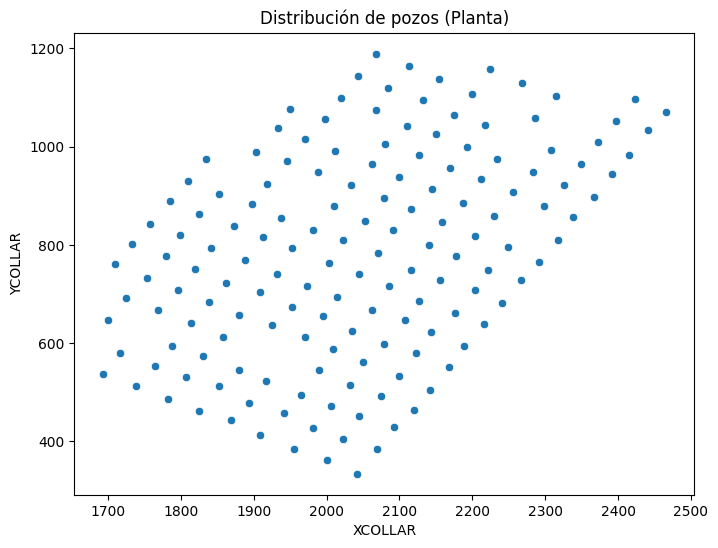

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma de coordenadas
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(collars["XCOLLAR"], kde=True, ax=axs[0, 0]).set_title("XCOLLAR")
sns.histplot(collars["YCOLLAR"], kde=True, ax=axs[0, 1]).set_title("YCOLLAR")
sns.histplot(collars["ZCOLLAR"], kde=True, ax=axs[1, 0]).set_title("ZCOLLAR")
sns.histplot(collars["DEPTH"], kde=True, ax=axs[1, 1]).set_title("DEPTH")
plt.tight_layout()
plt.show()

# Scatter para ver pozos en planta
plt.figure(figsize=(8, 6))
sns.scatterplot(data=collars, x="XCOLLAR", y="YCOLLAR")
plt.title("Distribución de pozos (Planta)")
plt.xlabel("XCOLLAR")
plt.ylabel("YCOLLAR")
plt.show()


### Litho

In [24]:
litho= pd.read_csv("litho.csv", sep=",")
litho.head()

,BHID,FROM,TO,ROCK
0,101,0.000000,120.318986,0.0
1,101,120.318986,121.776873,2.0
2,101,121.776873,124.276873,2.0
3,101,124.276873,126.776873,1.0
4,101,126.776873,129.276873,2.0


In [25]:
litho.describe().T

,count,mean,std,min,25%,50%,75%,max
BHID,7058.0,173.975914,43.397723,101.00000,139.000000,171.000000,206.000000,269.000000
FROM,7058.0,264.053418,91.484615,0.00000,203.798933,266.329355,335.315512,444.249650
TO,7058.0,271.757581,83.707399,36.91431,209.187837,270.926780,338.940865,445.681684
ROCK,7058.0,1.373477,0.614122,0.00000,1.000000,1.000000,2.000000,3.000000


In [26]:
litho.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7058 entries, 0 to 7057
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BHID    7058 non-null   int64  
 1   FROM    7058 non-null   float64
 2   TO      7058 non-null   float64
 3   ROCK    7058 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 220.7 KB


In [27]:
litho.isna().sum()


BHID    0
FROM    0
TO      0
ROCK    0
dtype: int64

In [28]:
# Merge con collars para obtener DEPTH
merged = litho.merge(collars[["BHID", "DEPTH"]], on="BHID", how="left")

# 1. TO >= FROM
invalid_intervals = merged[merged["TO"] < merged["FROM"]]
print(f"Intervalos donde TO < FROM: {len(invalid_intervals)}")

# 2. FROM o TO negativos
negatives = merged[(merged["FROM"] < 0) | (merged["TO"] < 0)]
print(f"Intervalos con FROM o TO negativos: {len(negatives)}")

# 3. BHID que no están en collars
bhid_diff = set(litho["BHID"]) - set(collars["BHID"])
print(f"BHID en litho pero no en collars: {len(bhid_diff)}")

# 4. TO > DEPTH (fuera del rango del sondaje)
out_of_bounds = merged[merged["TO"] > merged["DEPTH"]]
print(f"Intervalos donde TO excede DEPTH: {len(out_of_bounds)}")

# 5. Valores no enteros o extraños en ROCK
rock_values = litho["ROCK"].unique()
print(f"Valores únicos en ROCK: {sorted(rock_values)}")

# 6. Solapamientos dentro de un mismo BHID
overlaps = []
for bhid, group in litho.groupby("BHID"):
    sorted_group = group.sort_values("FROM")
    if (sorted_group["FROM"].values[1:] < sorted_group["TO"].values[:-1]).any():
        overlaps.append(bhid)
print(f"Sondajes con solapamientos de intervalos: {len(overlaps)}")


Intervalos donde TO < FROM: 0
Intervalos con FROM o TO negativos: 0
BHID en litho pero no en collars: 0
Intervalos donde TO excede DEPTH: 70
Valores únicos en ROCK: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0)]
Sondajes con solapamientos de intervalos: 0


In [29]:
# 1. Verificar si los 70 casos de TO > DEPTH son insignificantes (< 0.1 m)
excedidos = merged[merged["TO"] > merged["DEPTH"]]
excedidos["EXCESO"] = excedidos["TO"] - excedidos["DEPTH"]
excesivos = excedidos[excedidos["EXCESO"] > 0.1]
print(f"Intervalos donde TO excede DEPTH por más de 10 cm: {len(excesivos)}")

# 2. Conteo de valores en ROCK
rock_counts = litho["ROCK"].value_counts().sort_index()
print("Cantidad de registros por valor de ROCK:")
print(rock_counts)


Intervalos donde TO excede DEPTH por más de 10 cm: 0
Cantidad de registros por valor de ROCK:
ROCK
0.0     158
1.0    4453
2.0    2100
3.0     347
Name: count, dtype: int64


C:\TEMP\ipykernel_18408\2859887613.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excedidos["EXCESO"] = excedidos["TO"] - excedidos["DEPTH"]


In [30]:
# Filtrar registros con ROCK == 0
rock_cero = litho[litho["ROCK"] == 0]

print(f"Cantidad de registros con ROCK = 0: {len(rock_cero)}")
display(rock_cero)

Cantidad de registros con ROCK = 0: 158


,BHID,FROM,TO,ROCK
0,101,0.0,120.318986,0.0
33,102,0.0,121.303008,0.0
68,103,0.0,122.345690,0.0
106,104,0.0,110.830546,0.0
143,105,0.0,98.270570,0.0
...,...,...,...,...
6957,264,0.0,387.738692,0.0
6977,266,0.0,365.442207,0.0
7005,267,0.0,342.101404,0.0
7035,268,0.0,442.680286,0.0


### Surveys

In [31]:
surveys = pd.read_csv("surveys.csv", sep=",")
surveys.head()

,BHID,AT,BRG,DIP
0,101,0,0,90
1,102,0,0,90
2,103,0,0,90
3,104,0,0,90
4,105,0,0,90


In [32]:
surveys.describe().T

,count,mean,std,min,25%,50%,75%,max
BHID,158.0,183.582278,48.398849,101.0,143.25,182.5,224.75,269.0
AT,158.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
BRG,158.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
DIP,158.0,90.000000,0.000000,90.0,90.00,90.0,90.00,90.0


## Uno los cuadros en uno solo

In [33]:
# MERGE 1: Assays + Collars (por BHID)
assays_full = assays.merge(collars, on="BHID", how="left")

# MERGE 2: Assays + Litho (por BHID + FROM + TO)
# Primero redondeamos a 3 decimales para evitar problemas de coma flotante
assays_full["FROM"] = assays_full["FROM"].round(3)
assays_full["TO"] = assays_full["TO"].round(3)
litho["FROM"] = litho["FROM"].round(3)
litho["TO"] = litho["TO"].round(3)

assays_full = assays_full.merge(
    litho[["BHID", "FROM", "TO", "ROCK"]],
    on=["BHID", "FROM", "TO"],
    how="left"
)

# MERGE 3: Assays + Survey (por BHID)
assays_full = assays_full.merge(
    surveys[["BHID", "AT", "BRG", "DIP"]],
    on="BHID",
    how="left"
)

# REORDENAR columnas si querés claridad
cols = ["BHID", "FROM", "TO", "ROCK", "AU", "AG", "CU", "LENGTH",
        "XCOLLAR", "YCOLLAR", "ZCOLLAR", "DEPTH", "AT", "BRG", "DIP"]
assays_full = assays_full[cols]

# Mostramos un ejemplo
print(assays_full.head(10))

   BHID     FROM       TO  ROCK       AU          AG        CU      LENGTH  \
0   101    0.000  120.319   0.0      NaN         NaN       NaN  120.318986   
1   101  120.319  121.777   2.0  2.28340   49.611355  0.755315    1.457887   
2   101  121.777  124.277   2.0  4.03565  108.877250  0.069974    2.500000   
3   101  124.277  126.777   1.0  4.05984   92.622258  0.047699    2.500000   
4   101  126.777  129.277   2.0  1.36533   51.690519  0.117370    2.500000   
5   101  129.277  131.777   1.0  0.13079   44.648133  0.000000    2.500000   
6   101  131.777  134.277   1.0  0.16687   18.277408  0.000000    2.500000   
7   101  134.277  136.777   1.0  0.91266   45.595733  0.000000    2.500000   
8   101  136.777  139.277   1.0  1.25507   21.763276  0.000000    2.500000   
9   101  139.277  141.777   1.0  3.15250  111.936552  0.919865    2.500000   

       XCOLLAR     YCOLLAR     ZCOLLAR       DEPTH  AT  BRG  DIP  
0  1692.572266  537.331543  651.617371  197.862503   0    0   90  
1  1692

In [34]:
assays_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7058 entries, 0 to 7057
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BHID     7058 non-null   int64  
 1   FROM     7058 non-null   float64
 2   TO       7058 non-null   float64
 3   ROCK     7058 non-null   float64
 4   AU       7057 non-null   float64
 5   AG       7057 non-null   float64
 6   CU       7057 non-null   float64
 7   LENGTH   7058 non-null   float64
 8   XCOLLAR  7058 non-null   float64
 9   YCOLLAR  7058 non-null   float64
 10  ZCOLLAR  7058 non-null   float64
 11  DEPTH    7058 non-null   float64
 12  AT       7058 non-null   int64  
 13  BRG      7058 non-null   int64  
 14  DIP      7058 non-null   int64  
dtypes: float64(11), int64(4)
memory usage: 827.2 KB


In [35]:
assays_full.describe()

,BHID,FROM,TO,ROCK,AU,AG,CU,LENGTH,XCOLLAR,YCOLLAR,ZCOLLAR,DEPTH,AT,BRG,DIP
count,7058.000000,7058.000000,7058.000000,7058.000000,7057.000000,7057.000000,7057.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.0,7058.0,7058.0
mean,173.975914,264.053401,271.757564,1.373477,2.575875,72.289240,0.615126,7.704164,2023.270947,735.486440,584.679783,331.909826,0.0,0.0,90.0
std,43.397723,91.484620,83.707406,0.614122,1.990868,63.777227,0.913520,37.655371,165.572085,191.657466,33.227085,66.459645,0.0,0.0,0.0
min,101.000000,0.000000,36.914000,0.000000,0.000000,0.000000,0.000000,0.017708,1692.572266,334.410431,527.909485,144.891708,0.0,0.0,90.0
25%,139.000000,203.798750,209.187750,1.000000,1.141130,27.005223,0.000000,2.500000,1897.270386,588.693603,557.809631,293.044617,0.0,0.0,90.0
50%,171.000000,266.329500,270.927000,1.000000,2.127560,57.375440,0.000000,2.500000,2019.729858,732.824585,582.985596,335.265472,0.0,0.0,90.0
75%,206.000000,335.315250,338.940750,2.000000,3.542470,100.044648,1.042834,2.500000,2141.118896,878.434692,604.214356,385.280243,0.0,0.0,90.0
max,269.000000,444.250000,445.682000,3.000000,10.746490,319.162925,4.171336,442.680286,2466.167236,1189.137573,678.532227,445.681671,0.0,0.0,90.0


In [36]:
assays_full.isna().sum()


BHID       0
FROM       0
TO         0
ROCK       0
AU         1
AG         1
CU         1
LENGTH     0
XCOLLAR    0
YCOLLAR    0
ZCOLLAR    0
DEPTH      0
AT         0
BRG        0
DIP        0
dtype: int64

In [37]:
assays_full[assays_full[["AU", "AG", "CU"]].isnull().all(axis=1)]



,BHID,FROM,TO,ROCK,AU,AG,CU,LENGTH,XCOLLAR,YCOLLAR,ZCOLLAR,DEPTH,AT,BRG,DIP
0,101,0.0,120.319,0.0,NaN,NaN,NaN,120.318986,1692.572266,537.331543,651.617371,197.862503,0,0,90


In [38]:
assays_full.loc[assays_full[["AU", "AG", "CU"]].isnull().all(axis=1), ["AU", "AG", "CU"]] = 0 #SE CAMBIA NAN POR 0

In [39]:
# Verificamos si hay duplicados con mismo BHID, FROM y TO pero distinto ROCK
duplicados = assays_full.groupby(['BHID', 'FROM', 'TO'])['ROCK'].nunique().reset_index()
conflictivos = duplicados[duplicados['ROCK'] > 1]

print(f"Se encontraron {len(conflictivos)} intervalos con más de un tipo de ROCK asignado.")
display(conflictivos)


Se encontraron 0 intervalos con más de un tipo de ROCK asignado.


,BHID,FROM,TO,ROCK


In [40]:
# Filtramos el pozo 101
pozo_101 = assays_full[assays_full['BHID'] == 101]

# Ordenamos por las columnas 'FROM' y 'TO'
pozo_101.sort_values(by=['FROM', 'TO'], ascending=True)


,BHID,FROM,TO,ROCK,AU,AG,CU,LENGTH,XCOLLAR,YCOLLAR,ZCOLLAR,DEPTH,AT,BRG,DIP
0,101,0.000,120.319,0.0,0.00000,0.000000,0.000000,120.318986,1692.572266,537.331543,651.617371,197.862503,0,0,90
1,101,120.319,121.777,2.0,2.28340,49.611355,0.755315,1.457887,1692.572266,537.331543,651.617371,197.862503,0,0,90
2,101,121.777,124.277,2.0,4.03565,108.877250,0.069974,2.500000,1692.572266,537.331543,651.617371,197.862503,0,0,90
3,101,124.277,126.777,1.0,4.05984,92.622258,0.047699,2.500000,1692.572266,537.331543,651.617371,197.862503,0,0,90
4,101,126.777,129.277,2.0,1.36533,51.690519,0.117370,2.500000,1692.572266,537.331543,651.617371,197.862503,0,0,90
5,101,129.277,131.777,1.0,0.13079,44.648133,0.000000,2.500000,1692.572266,537.331543,651.617371,197.862503,0,0,90
6,101,131.777,134.277,1.0,0.16687,18.277408,0.000000,2.500000,1692.572266,537.331543,651.617371,197.862503,0,0,90
7,101,134.277,136.777,1.0,0.91266,45.595733,0.000000,2.500000,1692.572266,537.331543,651.617371,197.862503,0,0,90
8,101,136.777,139.277,1.0,1.25507,21.763276,0.000000,2.500000,1692.572266,537.331543,651.617371,197.862503,0,0,90
9,101,139.277,141.777,1.0,3.15250,111.936552,0.919865,2.500000,1692.572266,537.331543,651.617371,197.862503,0,0,90


In [41]:
print("Filas sin match en litho:", assays.shape[0] - assays_full['ROCK'].notnull().sum())


Filas sin match en litho: 0


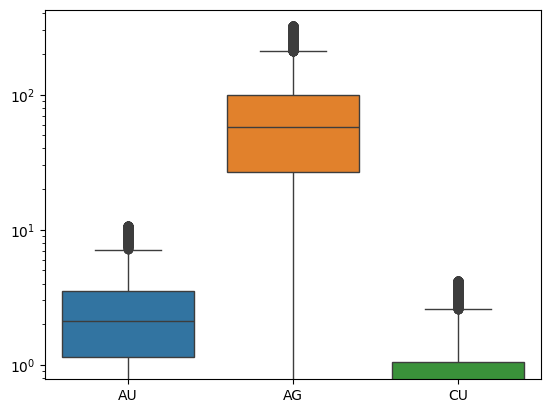

In [42]:
sns.boxplot(data=assays_full[['AU', 'AG', 'CU']])
plt.yscale("log")  # Las leyes suelen ser log-normal
plt.show()


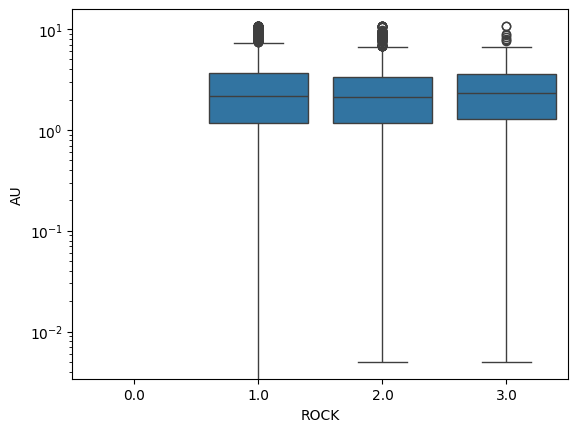

In [43]:
sns.boxplot(x="ROCK", y="AU", data=assays_full)
plt.yscale("log")
plt.show()

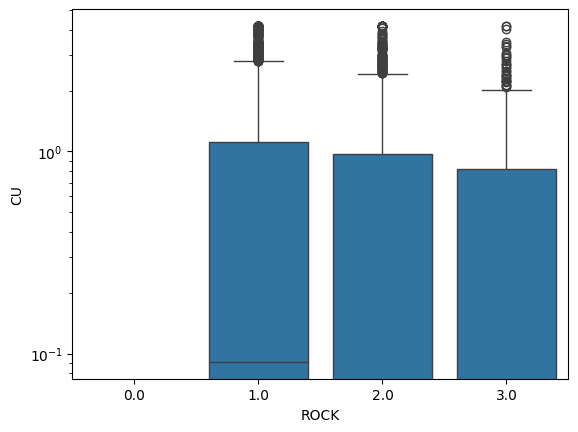

In [50]:
sns.boxplot(x="ROCK", y="CU", data=assays_full)
plt.yscale("log")
plt.show()

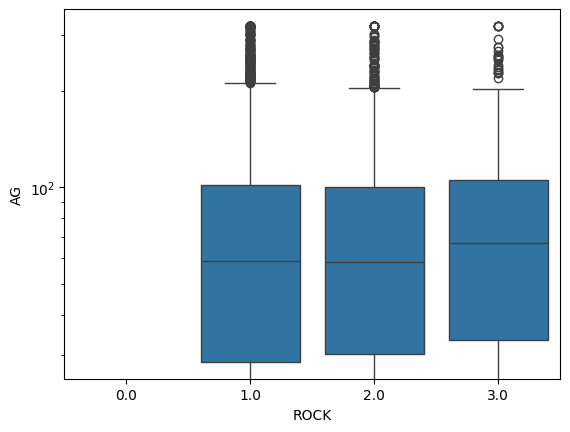

In [44]:
sns.boxplot(x="ROCK", y="AG", data=assays_full)
plt.yscale("log")
plt.show()

In [58]:
# Calcular promedio por litología para cada elemento
leyes_promedio = assays_full.groupby("ROCK")[["AU", "AG", "CU"]].mean().reset_index()

# Redondear para claridad (opcional)
leyes_promedio = leyes_promedio.round(3)

# Mostrar resultado
print(leyes_promedio)


   ROCK     AU      AG     CU
0   0.0  0.000   0.000  0.000
1   1.0  2.678  73.719  0.668
2   2.0  2.541  73.184  0.561
3   3.0  2.637  81.238  0.544


In [45]:
assays_full["ROCK"].value_counts(normalize=True)


ROCK
1.0    0.630915
2.0    0.297535
3.0    0.049164
0.0    0.022386
Name: proportion, dtype: float64

## Se eliminan las columnas irrelevantes y se exporta el archivo limpio para trabajarlo luego con RNA

In [46]:
# Eliminar las columnas irrelevantes
columns_to_drop = ['BHID', 'LENGTH', 'AT', 'BRG', 'DIP', 'DEPTH']
assays_cleaned = assays_full.drop(columns=columns_to_drop)

# Guardar el archivo CSV limpio
assays_cleaned.to_csv('assays_cleaned.csv', index=False)

In [5]:
assays_cleaned = pd.read_csv("assays_cleaned.csv", sep=",")


In [6]:
assays_cleaned.head()

,FROM,TO,ROCK,AU,AG,CU,XCOLLAR,YCOLLAR,ZCOLLAR
0,0.000,120.319,0.0,0.00000,0.000000,0.000000,1692.572266,537.331543,651.617371
1,120.319,121.777,2.0,2.28340,49.611355,0.755315,1692.572266,537.331543,651.617371
2,121.777,124.277,2.0,4.03565,108.877250,0.069974,1692.572266,537.331543,651.617371
3,124.277,126.777,1.0,4.05984,92.622258,0.047699,1692.572266,537.331543,651.617371
4,126.777,129.277,2.0,1.36533,51.690519,0.117370,1692.572266,537.331543,651.617371


In [7]:
assays_cleaned.describe()

,FROM,TO,ROCK,AU,AG,CU,XCOLLAR,YCOLLAR,ZCOLLAR
count,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000
mean,264.053401,271.757564,1.373477,2.575510,72.278998,0.615039,2023.270947,735.486440,584.679783
std,91.484620,83.707406,0.614122,1.990963,63.778513,0.913485,165.572085,191.657466,33.227085
min,0.000000,36.914000,0.000000,0.000000,0.000000,0.000000,1692.572266,334.410431,527.909485
25%,203.798750,209.187750,1.000000,1.141100,26.969382,0.000000,1897.270386,588.693603,557.809631
50%,266.329500,270.927000,1.000000,2.127405,57.374474,0.000000,2019.729858,732.824585,582.985596
75%,335.315250,338.940750,2.000000,3.540970,100.010849,1.041933,2141.118896,878.434692,604.214356
max,444.250000,445.682000,3.000000,10.746490,319.162925,4.171336,2466.167236,1189.137573,678.532227


In [8]:
assays_full = pd.read_csv("assays_cleaned.csv", sep=",")


In [9]:
assays_full.head()

,FROM,TO,ROCK,AU,AG,CU,XCOLLAR,YCOLLAR,ZCOLLAR
0,0.000,120.319,0.0,0.00000,0.000000,0.000000,1692.572266,537.331543,651.617371
1,120.319,121.777,2.0,2.28340,49.611355,0.755315,1692.572266,537.331543,651.617371
2,121.777,124.277,2.0,4.03565,108.877250,0.069974,1692.572266,537.331543,651.617371
3,124.277,126.777,1.0,4.05984,92.622258,0.047699,1692.572266,537.331543,651.617371
4,126.777,129.277,2.0,1.36533,51.690519,0.117370,1692.572266,537.331543,651.617371


### Graficamos

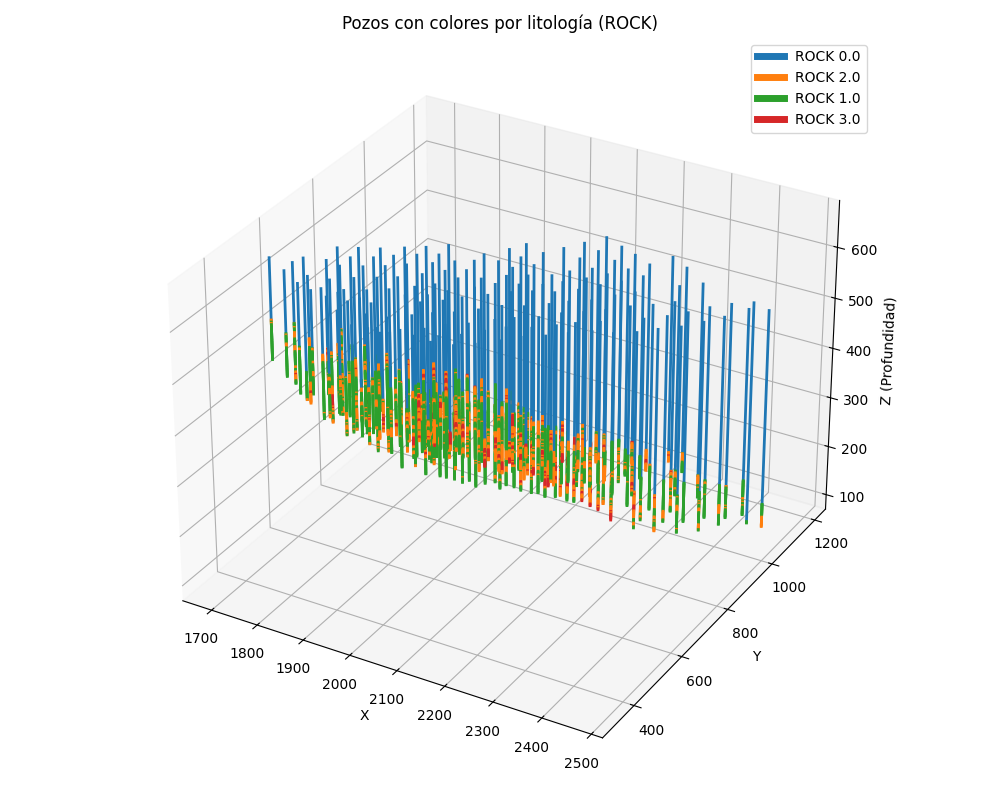

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

# Crear figura y ejes 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Definir colores por litología
unique_rocks = assays_full["ROCK"].unique()
colors = plt.cm.tab10.colors  # hasta 10 colores distintos
rock_color_map = dict(zip(unique_rocks, colors[:len(unique_rocks)]))

# Dibujar líneas de cada intervalo de perforación
for _, row in assays_full.iterrows():
    x = row["XCOLLAR"]
    y = row["YCOLLAR"]
    z_top = row["ZCOLLAR"] - row["FROM"]
    z_bot = row["ZCOLLAR"] - row["TO"]
    rock = row["ROCK"]
    color = rock_color_map.get(rock, 'black')

    ax.plot([x, x], [y, y], [z_top, z_bot], color=color, linewidth=2)

# Crear leyenda manual
for rock, color in rock_color_map.items():
    ax.plot([], [], [], color=color, label=f'ROCK {rock}', linewidth=5)

# Ajustar ejes
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z (Profundidad)")

ax.legend()
plt.title("Pozos con colores por litología (ROCK)")
plt.tight_layout()
plt.show()


### Creacion de modelo de bloques y delimitar por topografia y fondo de barreno

In [11]:
import numpy as np
import pandas as pd

# Dimensiones del bloque
block_size = 10

# Coordenadas extremas (caja bruta)
x_min, x_max = assays_full["XCOLLAR"].min(), assays_full["XCOLLAR"].max()
y_min, y_max = assays_full["YCOLLAR"].min(), assays_full["YCOLLAR"].max()
z_top = assays_full["ZCOLLAR"].max()
z_bot = (assays_full["ZCOLLAR"] - assays_full["TO"]).min()

# Rango con centroide en el centro del bloque
x_centers = np.arange(x_min + block_size/2, x_max, block_size)
y_centers = np.arange(y_min + block_size/2, y_max, block_size)
z_centers = np.arange(z_bot + block_size/2, z_top, block_size)

# Crear grilla
block_centroids = pd.DataFrame(
    [(x, y, z) for x in x_centers for y in y_centers for z in z_centers],
    columns=["X", "Y", "Z"]
)


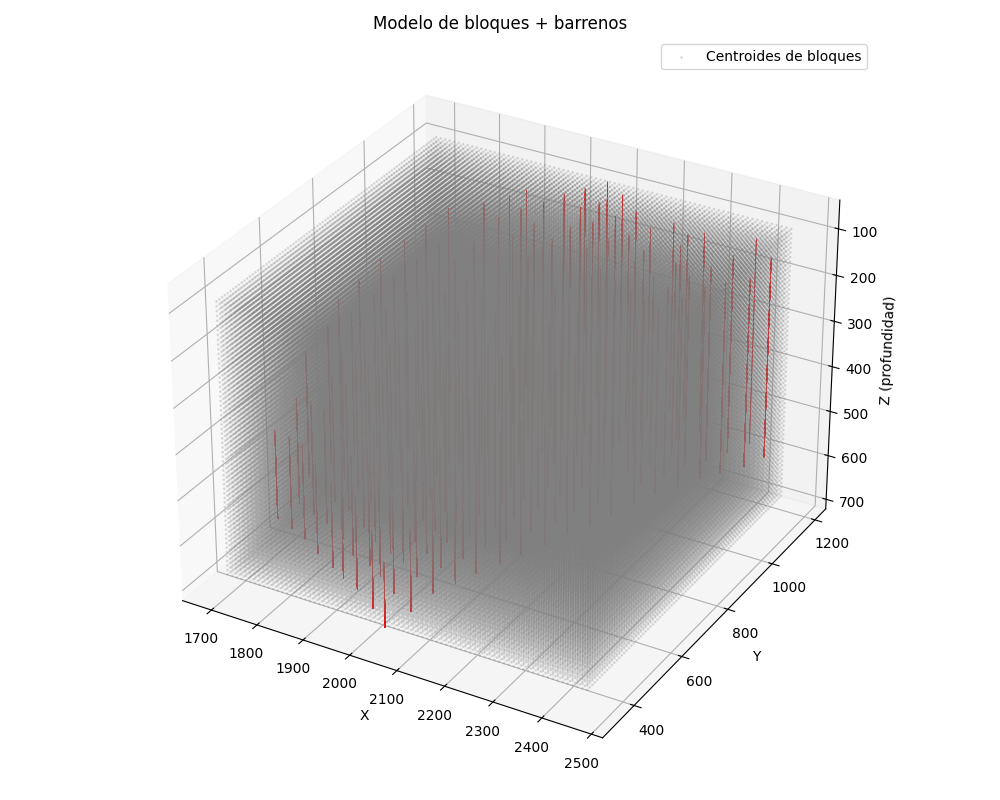

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Crear figura
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar centroides de los bloques, se le agrega el paramertro alfa para darle transparencia y que se veean los barrenos
ax.scatter(
    block_centroids['X'], block_centroids['Y'], block_centroids['Z'],
    color='gray', s=1, alpha=0.2, label='Centroides de bloques'  # alpha controla la transparencia
)


# Graficar los barrenos como líneas verticales
for _, row in assays_full.iterrows():
    x = row['XCOLLAR']
    y = row['YCOLLAR']
    z_top = row['ZCOLLAR']
    z_bot = row['ZCOLLAR'] - row['TO']
    ax.plot([x, x], [y, y], [z_top, z_bot], color='red', linewidth=0.5)

# Etiquetas
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z (profundidad)')
ax.set_title('Modelo de bloques + barrenos')

# Invertir eje Z para que profundidad crezca hacia abajo
ax.invert_zaxis()

plt.legend()
plt.tight_layout()
plt.show()


In [13]:
assays_cleaned.describe()

,FROM,TO,ROCK,AU,AG,CU,XCOLLAR,YCOLLAR,ZCOLLAR
count,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000
mean,264.053401,271.757564,1.373477,2.575510,72.278998,0.615039,2023.270947,735.486440,584.679783
std,91.484620,83.707406,0.614122,1.990963,63.778513,0.913485,165.572085,191.657466,33.227085
min,0.000000,36.914000,0.000000,0.000000,0.000000,0.000000,1692.572266,334.410431,527.909485
25%,203.798750,209.187750,1.000000,1.141100,26.969382,0.000000,1897.270386,588.693603,557.809631
50%,266.329500,270.927000,1.000000,2.127405,57.374474,0.000000,2019.729858,732.824585,582.985596
75%,335.315250,338.940750,2.000000,3.540970,100.010849,1.041933,2141.118896,878.434692,604.214356
max,444.250000,445.682000,3.000000,10.746490,319.162925,4.171336,2466.167236,1189.137573,678.532227


In [14]:
block_centroids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392700 entries, 0 to 392699
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X       392700 non-null  float64
 1   Y       392700 non-null  float64
 2   Z       392700 non-null  float64
dtypes: float64(3)
memory usage: 9.0 MB


In [15]:
import numpy as np
from tqdm import tqdm

# Convertir block_centroids a array para eficiencia
block_coords = block_centroids[['X', 'Y', 'Z']].values
included = np.zeros(len(block_coords), dtype=bool)

# Definir el radio de influencia
radio = 30  # metros

# Iterar sobre cada pozo y discretizar en Z cada 10 m
for _, row in tqdm(assays_full.iterrows(), total=len(assays_full)):
    x, y = row['XCOLLAR'], row['YCOLLAR']
    z_top = row['ZCOLLAR']
    z_bot = row['ZCOLLAR'] - row['TO']

    # Discretizar cada 10 metros a lo largo del pozo
    z_points = np.arange(z_top, z_bot, -30)
    coords = np.column_stack((np.full_like(z_points, x), np.full_like(z_points, y), z_points))

    # Calcular distancias a todos los bloques desde todos los puntos del pozo
    for point in coords:
        dists = np.linalg.norm(block_coords - point, axis=1)
        included |= dists <= radio

# Filtrar bloques que están cerca de algún pozo discretizado
filtered_blocks = block_centroids[included]


100%|██████████| 7058/7058 [16:44<00:00,  7.03it/s]


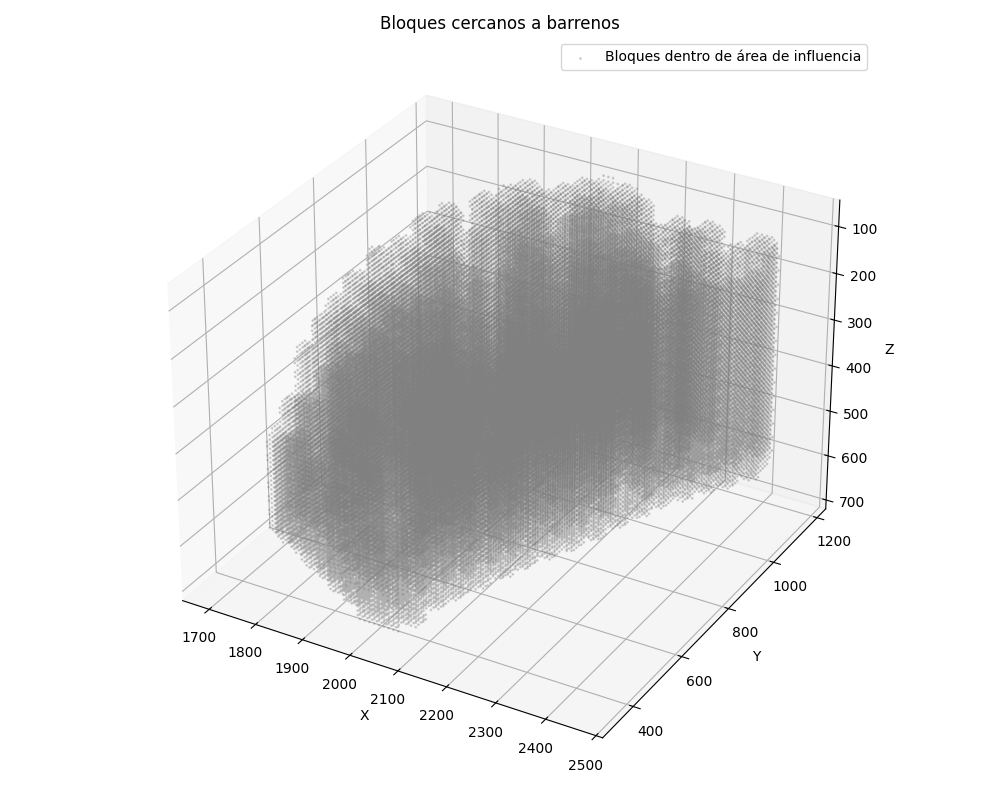

In [19]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Bloques filtrados
ax.scatter(filtered_blocks['X'], filtered_blocks['Y'], filtered_blocks['Z'],
           color='gray', s=1, alpha=0.3, label='Bloques dentro de área de influencia')



# Etiquetas y formato
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Bloques cercanos a barrenos')
ax.invert_zaxis()
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
filtered_blocks.to_csv("nube_filtrada.csv", index=False)


In [18]:
filtered_blocks = pd.read_csv("nube_filtrada.csv", sep=",")
